## imports

In [109]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve,average_precision_score,log_loss



## Create data frame for pre end and post end results

In [117]:
root_path = Path('./DebiasingProject/')

pre_results_files = [
    root_path / Path('test_pred_custom_4_999.csv'),
    root_path / Path('test_pred_custom_3_999.csv'),
    root_path / Path('test_pred_custom_2_999.csv'),
    root_path / Path('test_pred_custom_1_999.csv'),
    root_path / Path('test_pred_custom_0_999.csv'),
]

post_results_files = [
    root_path / Path('test_pred_train_04_27.csv'),
    root_path / Path('test_pred_train_04_28_29.csv'),
    root_path / Path('test_pred_train_04_28_31.csv'),
    root_path / Path('test_pred_end2_1.csv'),
    root_path / Path('test_pred_end3_2.csv'),
]
    

metadata_file = root_path / Path('metadata.json')

In [113]:
# read in metadata file 
with metadata_file.open() as f:
    metadata = json.load(f)
    
print(len(metadata))

# read in entire dataframe:
pre_end_df = []
for p in pre_results_files:
    print(p)
    df = pd.read_csv(p)
    is_fake = []
    skin_type = []
    to_del = []
    for index,row in df.iterrows():
        fn = row['filename']
        if fn in metadata.keys():
            # print('any')
            is_fake.append(metadata[fn]['is_fake'])
            skin_type.append(metadata[fn]['casual_conv_label']['skin-type'])
        else:
            to_del.append(index)
    
    df = df.drop(to_del)
    df['is-fake'] = is_fake
    df['skin-type'] = skin_type
    
    
    pre_end_df.append(df)

pre_end_df = pd.concat(pre_end_df)
print(pre_end_df.head())

print(len(pre_end_df))


# 
post_end_dfs = {}
for f in post_results_files:
    post_end_df = pd.read_csv(f)

    is_fake = []
    skin_type = []
    for index,row in post_end_df.iterrows():
        fn = row['filename']
        is_fake.append(metadata[fn]['is_fake'])
        skin_type.append(metadata[fn]['casual_conv_label']['skin-type'])


    post_end_df['skin-type'] = skin_type 
    post_end_df['is-fake'] = is_fake

    print(len(post_end_df))
    
    post_end_dfs[str(f)] = post_end_df

    

990
DebiasingProject\test_pred_custom_4_999.csv
test_pred_custom_3_999.csv


FileNotFoundError: [Errno 2] No such file or directory: 'test_pred_custom_3_999.csv'

## Calculate metrics

In [70]:
def calc_stats(df,alpha=100,gen_plots = False):
    cm = confusion_matrix(df['is-fake'],np.round(df['label']),labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    
    p = tp + fn
    n = tn + fp
    
    # print('positive',p)
    # print('negatives',n)
    
    # tpr = tp / p 
    # tnr = tn / n
    # ppv = tp / (tp + fp)
    # npv = tn / (tn + fn)
    # fnr = fn / p
    # fpr = fp / n
    
    # accuracy = (tp + tn) / (p + n)
    
    weighted_precision = np.log( tp / (tp + alpha * fp))
    recall = tp / (tp + fn)
    
    y_true = np.asarray(df['is-fake']) 
    y_hat = np.asarray(df['label'])
    
    logloss = log_loss(df['is-fake'],df['label'],labels = [0,1])
    

#     print('\taccuracy: ',round(accuracy,2))
    
#     print('\ttrue positive rate: ',round(tpr,2))
#     print('\ttrue negative rate: ',round(tnr,2))
#     print('\tpositive predictive value: ',round(ppv,2))
#     print('\tnegative predictive value: ',round(npv,2))
    

#     print('\tfalse negative rate : ',round(fnr,2))
#     print('\tfalse positive rate : ',round(fpr,2))
    
    # fpr1, tpr1, thresh1 = roc_curve(df['is-fake'], df['label'], pos_label=1)
    # auc_score = roc_auc_score(df['is-fake'], df['label'])
    
    ap_score = average_precision_score(df['is-fake'], df['label'])
    
    
    # print('\tAUC score: ',round(auc_score,2))
    # print('\tAverage Precision score: ',round(ap_score,2))
    print('\tWeighted Precision: ',round(weighted_precision,2))
    print('\tRecall: ',round(recall,2))
    print('\tLogLoss: ', round(logloss,2))
    
   
    
    if gen_plots:
        plt.plot(fpr1,tpr1)
        plt.title('ROC Curve')
        plt.show()

        pre1,re1,_ = precision_recall_curve(df['is-fake'], df['label'], pos_label=1)
        plt.plot(pre1,re1)
        plt.title('Precision-recall curve')
        plt.show()
        
    return weighted_precision,recall,logloss
    

In [71]:
# Overall accuracy 
print('Pre EnD')
print('Overall Accuracy')
wp,r,ll = calc_stats(pre_end_df)
# confusion matrix by skin type

# results = {}

# results['pre'] = {
#     'all':(wp,r,ll)
# }
results = []
col = []
col.append((wp,r,ll))


for t in ['1','2','3','4','5','6']:
    
    df_new = pre_end_df[pre_end_df['skin-type'] == t]
    
    print('Skin Type: ' + t)
    wp,r,ll = calc_stats(df_new)
    # results['pre'][t] = (wp,r,ll)
    col.append((wp,r,ll))
    
results.append(col)
    

 
print('Post EnD')
for name,df in post_end_dfs.items():
    new_col = []  
    print(name)
    print('Overall Accuracy')
    wp,r,ll=calc_stats(df)
    # confusion matrix by skin type
    # results['post'] = {
    #     'all':(wp,r,ll)
    # }
    new_col.append((wp,r,ll))
    for t in ['1','2','3','4','5','6']:

        df_new = df[df['skin-type'] == t]

        print('Skin Type: ' + t)
        wp,r,ll = calc_stats(df_new)
        # results['post'][t] = (wp,r,ll)
        
        new_col.append((wp,r,ll))
    results.append(new_col)
        
    
    

Pre EnD
Overall Accuracy
	Weighted Precision:  -2.63
	Recall:  0.93
	LogLoss:  0.25
Skin Type: 1
	Weighted Precision:  0.0
	Recall:  0.92
	LogLoss:  0.12
Skin Type: 2
	Weighted Precision:  -2.81
	Recall:  0.94
	LogLoss:  0.27
Skin Type: 3
	Weighted Precision:  -2.26
	Recall:  0.95
	LogLoss:  0.18
Skin Type: 4
	Weighted Precision:  0.0
	Recall:  0.96
	LogLoss:  0.09
Skin Type: 5
	Weighted Precision:  -3.26
	Recall:  0.94
	LogLoss:  0.31
Skin Type: 6
	Weighted Precision:  -3.7
	Recall:  0.82
	LogLoss:  0.36
Post EnD
test_pred_train_04_27.csv
Overall Accuracy
	Weighted Precision:  -3.61
	Recall:  0.77
	LogLoss:  0.69
Skin Type: 1
	Weighted Precision:  0.0
	Recall:  0.88
	LogLoss:  0.17
Skin Type: 2
	Weighted Precision:  -3.55
	Recall:  0.71
	LogLoss:  0.64
Skin Type: 3
	Weighted Precision:  -3.73
	Recall:  0.65
	LogLoss:  0.92
Skin Type: 4
	Weighted Precision:  0.0
	Recall:  0.91
	LogLoss:  0.15
Skin Type: 5
	Weighted Precision:  -4.3
	Recall:  0.94
	LogLoss:  0.83
Skin Type: 6
	Weighted 

In [81]:
header = '\t\t'+'\t'.join(['pre end\t'] + list(post_end_dfs.keys()))
print(header)
print('-'*round(len(header)*1.3))

types = ['all','1','2','3','4','5','6']
for i in range(len(types)):
    k = types[i]
    print(k)
    line1 = '\twP\t\t'
    line2 = '\tRecall\t\t'
    line3 = '\tLogloss\t\t'
    
    for j in range(len(results)):
        line1 +=  str(np.round(results[j][i][0],2)) + '\t\t\t'
        line2 += str(np.round(results[j][i][1],2)) + '\t\t\t'
        line3 +=  str(np.round(results[j][i][2],2)) + '\t\t\t'
    print(line1)
    print(line2)
    print(line3)
    
print('Mean/STD')
line1 = '\twP\t\t'
line2 = '\tRecall\t\t'
line3 = '\tLogloss\t\t'

for j in range(len(results)):
    line1 +=  str(np.round(np.mean([vals[0] for vals in results[j][:]]),2)) + ' / ' + str(np.round(np.std([vals[0] for vals in results[j][:]]),2)) + '\t\t'
    line2 += str(np.round(np.mean([vals[1] for vals in results[j][:]]),2)) + ' / ' + str(np.round(np.std([vals[1] for vals in results[j][:]]),2)) + '\t\t'
    line3 +=  str(np.round(np.mean([vals[2] for vals in results[j][:]]),2)) + ' / ' + str(np.round(np.std([vals[2] for vals in results[j][:]]),2)) + '\t\t'
    
print(line1)
print(line2)
print(line3)
        
#     prewp = results['pre'][k][0] 
#     postwp = results['post'][k][0] 
#     prer = results['pre'][k][1] 
#     postr = results['post'][k][1] 
#     prell = results['pre'][k][2] 
#     postll = results['post'][k][2] 
    
#     print(f'\twP: \t\t{round(prewp,2)} \t{round(postwp,2)}')
#     print(f'\tRecall: \t{round(prer,2)} \t{round(postr,2)}')      
#     print(f'\tlogloss: \t{round(prell,2)} \t{round(postll,2)}')  

# std of each over all skin types

		pre end		test_pred_train_04_27.csv	test_pred_train_04_28_29.csv	test_pred_train_04_28_31.csv	test_pred_end2_1.csv	test_pred_end3_2.csv
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
all
	wP		-2.63			-3.61			-2.9			-2.97			-2.98			-3.17			
	Recall		0.93			0.77			0.89			0.87			0.89			0.83			
	Logloss		0.25			0.69			0.34			0.4			0.36			0.41			
1
	wP		0.0			0.0			0.0			0.0			0.0			0.0			
	Recall		0.92			0.88			0.94			0.98			0.84			0.9			
	Logloss		0.12			0.17			0.15			0.1			0.3			0.16			
2
	wP		-2.81			-3.55			-2.97			-2.96			-2.75			-2.94			
	Recall		0.94			0.71			0.84			0.8			0.88			0.82			
	Logloss		0.27			0.64			0.37			0.44			0.28			0.36			
3
	wP		-2.26			-3.73			-2.96			-3.09			-2.44			-3.22			
	Recall		0.95			0.65			0.85			0.83			0.86			0.72			
	Logloss		0.18			0.92			0.36			0.45			0.28			0.46			
4
	wP		0.0			0.0			0.0			0.0			0.0			0.0			
	Recall		0.96

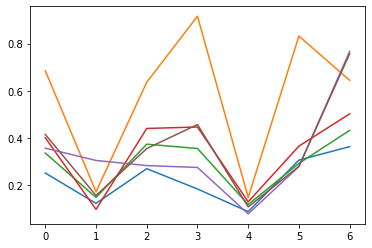

In [79]:
import matplotlib.pyplot as plt


types = ['all','1','2','3','4','5','6']

runs = ['pre end\t'] + list(post_end_dfs.keys())

all_data = {}

for r in runs:
    all_data[r] = []

for i in range(len(types)):
    k = types[i]
    # print(k)
    # line1 = '\twP\t\t'
    # line2 = '\tRecall\t\t'
    # line3 = '\tLogloss\t\t'
    
    for j in range(len(results)):
        r = runs[j]
        # line1 +=  str(np.round(results[j][i][0],2)) + '\t\t\t'
        # line2 += str(np.round(results[j][i][1],2)) + '\t\t\t'
        # line3 +=  str(np.round(results[j][i][2],2)) + '\t\t\t'
        all_data[r].append(results[j][i][2])
    
for k,data in all_data.items():
    plt.plot(data)


In [82]:
# test set by skin color:
real = []
fake = []
for t in ['1','2','3','4','5','6']:
    
    df_new = post_end_df[post_end_df['skin-type'] == t]
    print('skin type ' + t)
    print('\tnum: ',len(df_new))
    print('\tnum real: ',len(df_new[df_new['is-fake'] == 0]))
    real.append(len(df_new[df_new['is-fake'] == 0]))
    print('\tnum fake: ',len(df_new[df_new['is-fake'] == 1]))    
    fake.append(len(df_new[df_new['is-fake'] == 1]))

skin type 1
	num:  49
	num real:  0
	num fake:  49
skin type 2
	num:  261
	num real:  152
	num fake:  109
skin type 3
	num:  251
	num real:  141
	num fake:  110
skin type 4
	num:  71
	num real:  17
	num fake:  54
skin type 5
	num:  174
	num real:  127
	num fake:  47
skin type 6
	num:  184
	num real:  144
	num fake:  40


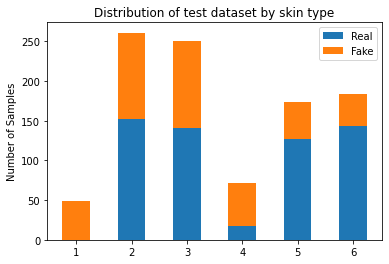

In [89]:
labels = ['1','2','3','4','5','6']
width = 0.5

fig, ax = plt.subplots()

ax.bar(labels, real, width,  label='Real')
ax.bar(labels, fake, width, bottom=real,
       label='Fake')

ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of test dataset by skin type')
ax.legend()

plt.show()

# whole data set bar graph

skin type 1
	num:  203
	num real:  38
	num fake:  165
skin type 2
	num:  1390
	num real:  688
	num fake:  702
skin type 3
	num:  1247
	num real:  599
	num fake:  648
skin type 4
	num:  383
	num real:  171
	num fake:  212
skin type 5
	num:  814
	num real:  431
	num fake:  383
skin type 6
	num:  909
	num real:  538
	num fake:  371


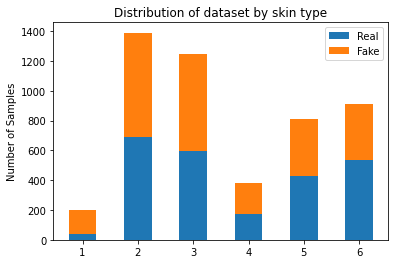

In [119]:

# real = []
# fake = []
# for t in ['1','2','3','4','5','6']:
    
#     df_new = post_end_df[post_end_df['skin-type'] == t]
#     print('skin type ' + t)
#     print('\tnum: ',len(df_new))
#     print('\tnum real: ',len(df_new[df_new['is-fake'] == 0]))
#     real.append(len(df_new[df_new['is-fake'] == 0]))
#     print('\tnum fake: ',len(df_new[df_new['is-fake'] == 1]))    
#     fake.append(len(df_new[df_new['is-fake'] == 1]))
    
# print(metadata)
# make df of all data

# read in metadata file 
metadata_file = root_path / Path('metadata-sanitized.json')

with metadata_file.open() as f:
    metadata = json.load(f)


filenames = list(metadata.keys())
is_fake = [metadata[k]['is_fake'] for k in metadata.keys()]
skin_type = [metadata[k]['casual_conv_label']['skin-type'] for k in metadata.keys()]

d = {
    'filename': filenames,
    'is-fake': is_fake,
    'skin-type': skin_type,
    
}

df = pd.DataFrame(d)

# test set by skin color:
real = []
fake = []
for t in ['1','2','3','4','5','6']:
    
    df_new = df[df['skin-type'] == t]
    print('skin type ' + t)
    print('\tnum: ',len(df_new))
    print('\tnum real: ',len(df_new[df_new['is-fake'] == 0]))
    real.append(len(df_new[df_new['is-fake'] == 0]))
    print('\tnum fake: ',len(df_new[df_new['is-fake'] == 1]))    
    fake.append(len(df_new[df_new['is-fake'] == 1]))

    
labels = ['1','2','3','4','5','6']
width = 0.5

fig, ax = plt.subplots()

ax.bar(labels, real, width,  label='Real')
ax.bar(labels, fake, width, bottom=real,
       label='Fake')

ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of dataset by skin type')
ax.legend()

plt.show()
